In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
from collections import Counter
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler, OrdinalEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split,StratifiedKFold,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, accuracy_score,roc_auc_score,f1_score, precision_recall_curve, auc, average_precision_score,PrecisionRecallDisplay,RocCurveDisplay,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from xgboost import XGBClassifier
import shap
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK,space_eval
from hyperopt.pyll import scope
from scipy.stats import uniform 
from scipy.stats import randint 
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import mlflow
from lightgbm import LGBMClassifier

In [2]:
df=pd.read_csv("data/application_data.csv")

# feature engineering on address discrepancies and document count
df['document']= df['FLAG_DOCUMENT_2']+df['FLAG_DOCUMENT_3']+df['FLAG_DOCUMENT_4']+df['FLAG_DOCUMENT_5']+df['FLAG_DOCUMENT_6']\
           +df['FLAG_DOCUMENT_7']+df['FLAG_DOCUMENT_8']+df['FLAG_DOCUMENT_9']+df['FLAG_DOCUMENT_10']+df['FLAG_DOCUMENT_11']\
           +df['FLAG_DOCUMENT_12']+df['FLAG_DOCUMENT_13']+df['FLAG_DOCUMENT_14']+df['FLAG_DOCUMENT_15']+df['FLAG_DOCUMENT_16']\
           +df['FLAG_DOCUMENT_17']+df['FLAG_DOCUMENT_18']+df['FLAG_DOCUMENT_19']+df['FLAG_DOCUMENT_20']+df['FLAG_DOCUMENT_21']

df['address'] = df['REG_REGION_NOT_LIVE_REGION']+df['REG_REGION_NOT_WORK_REGION']+df['LIVE_REGION_NOT_WORK_REGION']\
            +df['REG_CITY_NOT_LIVE_CITY']+df['REG_CITY_NOT_WORK_CITY']+df['LIVE_CITY_NOT_WORK_CITY']

drop_col = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
           'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
            'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

df.drop(columns=drop_col,inplace=True)

# drop columns with over 50% missing and the ID column, FLAG_MOBIL is 100% 1, REGION_RATING_CLIENT_W_CITY correlates with REGION_RATING_CLIENT
drop_col = ['OWN_CAR_AGE','EXT_SOURCE_1','APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
            'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
            'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
            'BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE','ELEVATORS_MODE', 
            'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE','LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
            'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI','BASEMENTAREA_MEDI', 
            'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI','COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
            'FLOORSMAX_MEDI','FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI', 
            'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
            'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE','SK_ID_CURR','FLAG_MOBIL','REGION_RATING_CLIENT_W_CITY']

df.drop(columns=drop_col,inplace=True)

# preprocessing outside of pipeline
#df['DAYS_LAST_PHONE_CHANGE']=df['DAYS_LAST_PHONE_CHANGE'].fillna(1)
#df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].fillna(df['CNT_CHILDREN']+1)
#df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna("Others")
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243:0})
#df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna("Missing")

df.shape

(307511, 46)

In [3]:
num_features1 = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                'EXT_SOURCE_2','DAYS_LAST_PHONE_CHANGE','OBS_30_CNT_SOCIAL_CIRCLE',
                'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                'document','address'] # no missing indicator
num_features2 = ['EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'] # add missing indicator
cat_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE']
# binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
#                    'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
#                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2', 
#                    'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
#                    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
#                    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
#                    'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[num_features1+num_features2+cat_features+binary_features], df['TARGET'],
                                                    stratify=df['TARGET'], test_size=0.2,random_state=42)

In [5]:
# for tree based model, no need to scale numerical variable and use ordinal encoder for categorical variable
numeric_transformer1 = Pipeline(
    steps=[#("imputer",SimpleImputer(strategy = 'median'))
        ("pass","passthrough")
          ]
)
numeric_transformer2 = Pipeline(
    steps=[#("imputer",SimpleImputer(strategy = 'median', add_indicator=True))
        ("pass","passthrough")
          ]
)
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", max_categories=10, unknown_value=-1))
          ]
)
binary_transformer = Pipeline(
    steps=[
        ('pass','passthrough')
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num1", numeric_transformer1, num_features1),
        ("num2", numeric_transformer2, num_features2),
        ("cat", categorical_transformer, cat_features),
        ('binary',binary_transformer,binary_features)],
    #remainder='passthrough'
)

### RANDOM FOREST

RandomizedSearchCV

In [57]:
pipe = Pipeline(
    steps=[("preprocessor",preprocessor),
           ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))]
)
param = { "classifier__max_depth":randint(2,7),
          "classifier__min_samples_split":randint(2,5),
          "classifier__min_samples_leaf":randint(2,5),
          "classifier__ccp_alpha": uniform(0,100)
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv1 = RandomizedSearchCV(pipe, param_distributions=param, cv=cv, scoring="average_precision",random_state=42)
rf_cv1.fit(X_train,y_train)

print("Best parameter:", rf_cv1.best_params_)
print("Best CV score:", rf_cv1.cv_results_['mean_test_score'].max())

Best parameter: {'classifier__ccp_alpha': 37.454011884736246, 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3}
Best CV score: 0.08072908198907737


RandomizedSearchCV, Undersampling

In [156]:
# undersampling
pipe = Pipeline(
    steps=[("undersampler", RandomUnderSampler()),
           ("preprocessor", preprocessor),
           ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))
            ]
)
param = { "classifier__max_depth":randint(2,7),
          "classifier__min_samples_split":randint(2,5),
          "classifier__min_samples_leaf":randint(2,5),
          "classifier__ccp_alpha": uniform(0,100)
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv1 = RandomizedSearchCV(pipe, param_distributions=param, cv=cv, scoring="average_precision",random_state=42)
rf_cv1.fit(X_train,y_train)

print("Best parameter:", rf_cv1.best_params_)
print("Best CV score:", rf_cv1.cv_results_['mean_test_score'].max())

Best parameter: {'classifier__ccp_alpha': 37.454011884736246, 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4}
Best CV score: 0.08072908198907737


HyperOpt, SMOTE

In [17]:
def objective(param):
    pipe = Pipeline(steps=[
           ("preprocessor",preprocessor),
           ("smote",SMOTE(random_state=42)),
           ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))])
    pipe.set_params(**param) 
    
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])

    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,10)),
         'classifier__min_samples_split' : scope.int(hp.uniform('min_samples_split', 2,10)),
         'classifier__ccp_alpha':hp.uniform('ccp_alpha',0,100)
        }

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)

100%|███████████████████████████████████████████████| 10/10 [05:01<00:00, 30.16s/trial, best loss: -0.0807284256737531]


HyperOpt, Balanced RF

In [231]:
# A balanced random forest randomly under-samples each bootstrap sample to balance it.
def objective(param):
    pipe = Pipeline(steps=[("preprocessor",preprocessor),
           ('classifier', BalancedRandomForestClassifier(sampling_strategy = 'majority',random_state=42,n_jobs=-1,
                                                         class_weight='balanced',replacement=False))])
    pipe.set_params(**param) 
    
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])

    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,10)),
         'classifier__min_samples_split' : scope.int(hp.uniform('min_samples_split', 2,10)),
         'classifier__ccp_alpha':hp.uniform('ccp_alpha',0,200)
        }

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)

100%|███████████████████████████████████████████████| 10/10 [02:40<00:00, 16.05s/trial, best loss: -0.0807284256737531]


In [18]:
result

{'ccp_alpha': 98.83414154382557,
 'max_depth': 10.0,
 'min_samples_leaf': 7.909196015358564,
 'min_samples_split': 2.5980863289889626,
 'strategy': 1}

### XGBOOST

SMOTE

In [25]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ("smote",SMOTE(random_state=42)),
                           ('classifier', XGBClassifier(scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__eta': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,6,2)),
         'classifier__min_child_weight': hp.uniform('min_child_weight', 1,10),
         'classifier__lambda' : hp.uniform('lambda', 1,10),
         'classifier__subsample':hp.uniform('subsample',0,1),
         'classifier__gamma':hp.uniform('gamma',0,10),
         'classifier__scale_pos_weight':hp.choice('weight',[1])
}

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=20
)

100%|███████████████████████████████████████████████| 20/20 [20:57<00:00, 62.90s/trial, best loss: -0.2279901603974212]


Undersampling

In [257]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', XGBClassifier(scale_pos_weight=(yy_train==0).sum()/(yy_train==1).sum()))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__eta': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,6,2)),
         'classifier__min_child_weight': hp.uniform('min_child_weight', 1,10),
         'classifier__lambda' : hp.uniform('lambda', 1,10),
         'classifier__subsample':hp.uniform('subsample',0,1),
         'classifier__gamma':hp.uniform('gamma',0,10),
         #'classifier__scale_pos_weight':hp.choice('weight',[1])
}

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=64
)

100%|██████████████████████████████████████████████| 64/64 [21:51<00:00, 20.49s/trial, best loss: -0.23836420359096233]


MLFlow tracking

In [26]:
def objective(param):

    with mlflow.start_run(nested=True): 
        mlflow.log_params(param)
        XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
        weight_imbalance = (yy_train==0).sum()/(yy_train==1).sum()
    
        pipe = Pipeline(steps=[("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', XGBClassifier(scale_pos_weight = weight_imbalance))])
        pipe.set_params(**param) 
    
        pipe.fit(XX_train,yy_train)
        yy_pred_proba = pipe.predict_proba(XX_test)
        yy_pred = pipe.predict(XX_test)
        ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
        roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
        acc = accuracy_score(yy_test, yy_pred)
        logloss = log_loss(yy_test, yy_pred_proba[:, 1])
        mlflow.log_metric("val_PRC_AUC", ap)
        mlflow.log_metric("val_ROC_AUC", roc)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_log_loss", logloss)
    return {"loss": -ap,
                "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__eta': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_child_weight': hp.uniform('min_child_weight', 1,10),
         'classifier__lambda' : hp.uniform('lambda', 1,10),
         'classifier__subsample':hp.uniform('subsample',0,1),
         'classifier__gamma':hp.uniform('gamma',0,10),
         #'classifier__scale_pos_weight':hp.choice('scale_pos_weight',[1]),
}



# start a client
client = mlflow.tracking.MlflowClient()

# start an experiment
try:
    client.create_experiment("loan")
except:
    experiment = client.get_experiment_by_name("loan")
    
# set a global active experiment across parent and child runs
mlflow.set_experiment(experiment_name='loan')

# start a run
run = client.create_run(experiment.experiment_id)
with mlflow.start_run(run_id=run.info.run_id):
    result = fmin(fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=Trials(),
        max_evals=2)
    result = {k:float(v) for k,v in result.items()}
    mlflow.log_params(space_eval(param,result))
    mlflow.log_dict(result,"best_params.json")
    mlflow.set_tag("model","XGBoost")
    
    # search experiments to log the best metrics
    experiment_id = experiment.experiment_id
    run_id = run.info.run_id
    runs = client.search_runs(
            [experiment_id], "tags.mlflow.parentRunId = '{run_id}' ".format(run_id=run.info.run_id)
        )
    _inf = np.finfo(np.float64).min
    best_val_PRC_AUC = _inf
    best_val_ROC_AUC = _inf
    best_val_accuracy = _inf
    best_val_log_loss = _inf
    for r in runs:
        if r.data.metrics["val_PRC_AUC"] > best_val_PRC_AUC:
            best_val_ROC_AUC = r.data.metrics["val_ROC_AUC"]
            best_val_accuracy = r.data.metrics["val_accuracy"]
            best_val_log_loss = r.data.metrics["val_log_loss"]
            best_val_PRC_AUC = r.data.metrics["val_PRC_AUC"]
    mlflow.log_metrics(
                {
                    "val_ROC_AUC": best_val_ROC_AUC,
                    "val_PRC_AUC": best_val_PRC_AUC,
                    "val_log_loss": best_val_log_loss,
                    "val_accuracy": best_val_accuracy
                }
            )

100%|████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.56s/trial, best loss: -0.12028085166385541]


In [258]:
result

{'eta': 0.28715047020268525,
 'gamma': 2.6923449065374774,
 'lambda': 2.977695707610445,
 'max_depth': 2.0,
 'min_child_weight': 3.788857718051868,
 'subsample': 0.9846407705580316}

### HISTGRADIENTBOOSTING

In [10]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', HistGradientBoostingClassifier(class_weight='balanced',
                                                                         #categorical_features=range(27,45)
                                                                        ))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
#    loss = log_loss(yy_test,yy_pred[:,1])
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 5,200)),
         'classifier__l2_regularization' : hp.uniform('lambda', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.uniform('max_leaf_nodes',5,200))
         #'classifier__scale_pos_weight':hp.choice('weight',[1])
}

trials = Trials()

result = fmin(
        fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=trials,
        max_evals=10
    )


100%|████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/trial, best loss: 0.5954543173799873]


Undersampling

In [240]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', HistGradientBoostingClassifier(class_weight='balanced',
                                                                         #categorical_features=range(27,45)
                                                                        ))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 5,200)),
         'classifier__l2_regularization' : hp.uniform('lambda', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.uniform('max_leaf_nodes',5,200)),
         'classifier__class_weight':hp.choice('weight',[None])
}

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=64
)

100%|██████████████████████████████████████████████| 64/64 [01:33<00:00,  1.47s/trial, best loss: -0.23590470837446603]


MLflow tracking

In [7]:
def objective(param):

    with mlflow.start_run(nested=True): 
        mlflow.log_params(param)
        XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
        pipe = Pipeline(steps=[("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', HistGradientBoostingClassifier())])
        pipe.set_params(**param) 
    
        pipe.fit(XX_train,yy_train)
        yy_pred_proba = pipe.predict_proba(XX_test)
        yy_pred = pipe.predict(XX_test)
        ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
        roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
        acc = accuracy_score(yy_test, yy_pred)
        logloss = log_loss(yy_test, yy_pred_proba[:, 1])
        mlflow.log_metric("val_PRC_AUC", ap)
        mlflow.log_metric("val_ROC_AUC", roc)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_log_loss", logloss)
    return {"loss": -ap,
                "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.uniform('learning_rate',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 5,200)),
         'classifier__l2_regularization' : hp.uniform('l2_regularization', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.uniform('max_leaf_nodes',5,200)),
         'classifier__class_weight':hp.choice('class_weight',["balanced"])
}



# start a client
client = mlflow.tracking.MlflowClient()

# start an experiment
try:
    client.create_experiment("loan")
except:
    experiment = client.get_experiment_by_name("loan")
    
# set a global active experiment across parent and child runs
mlflow.set_experiment(experiment_name='loan')

# start a run
run = client.create_run(experiment.experiment_id)
with mlflow.start_run(run_id=run.info.run_id):
    result = fmin(fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=Trials(),
        max_evals=2)
    result = {k:float(v) for k,v in result.items()}
    mlflow.log_params(space_eval(param,result))
    mlflow.log_dict(result,"best_params.json")
    mlflow.set_tag("model","HistGradientBoosting")
    
    # search experiments to log the best metrics
    experiment_id = experiment.experiment_id
    run_id = run.info.run_id
    runs = client.search_runs(
            [experiment_id], "tags.mlflow.parentRunId = '{run_id}' ".format(run_id=run.info.run_id)
        )
    _inf = np.finfo(np.float64).min
    best_val_PRC_AUC = _inf
    best_val_ROC_AUC = _inf
    best_val_accuracy = _inf
    best_val_log_loss = _inf
    for r in runs:
        if r.data.metrics["val_PRC_AUC"] > best_val_PRC_AUC:
            best_val_ROC_AUC = r.data.metrics["val_ROC_AUC"]
            best_val_accuracy = r.data.metrics["val_accuracy"]
            best_val_log_loss = r.data.metrics["val_log_loss"]
            best_val_PRC_AUC = r.data.metrics["val_PRC_AUC"]
    mlflow.log_metrics(
                {
                    "val_ROC_AUC": best_val_ROC_AUC,
                    "val_PRC_AUC": best_val_PRC_AUC,
                    "val_log_loss": best_val_log_loss,
                    "val_accuracy": best_val_accuracy
                }
            )

100%|████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/trial, best loss: -0.20806787049267356]


In [40]:
result

{'class_weight': 0.0,
 'l2_regularization': 8.008941566201596,
 'learning_rate': 0.29305364694969455,
 'max_depth': 4.0,
 'max_leaf_nodes': 74.57094257536562,
 'min_samples_leaf': 100.68769976033155}

### LIGHTGBM

In [39]:
def objective(param):

    with mlflow.start_run(nested=True): 
        mlflow.log_params(param)
        XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
        pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', LGBMClassifier(verbosity=-1))])
        pipe.set_params(**param) 
    
        pipe.fit(XX_train,yy_train)
        yy_pred_proba = pipe.predict_proba(XX_test)
        yy_pred = pipe.predict(XX_test)
        ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
        roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
        acc = accuracy_score(yy_test, yy_pred)
        logloss = log_loss(yy_test, yy_pred_proba[:, 1])
        mlflow.log_metric("val_PRC_AUC", ap)
        mlflow.log_metric("val_ROC_AUC", roc)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_log_loss", logloss)
    return {"loss": -ap,
                "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.uniform('learning_rate',0,1),
         'classifier__max_depth': scope.int(hp.uniform('max_depth', 2,10)),
         'classifier__min_data_in_leaf': scope.int(hp.uniform('min_data_in_leaf', 10,200)),
         'classifier__lambda_l2' : hp.uniform('lambda_l2', 1,10),
         'classifier__num_leaves':scope.int(hp.uniform('num_leaves',10,200)),
         'classifier__feature_fraction':hp.uniform('feature_fraction',0,1),
         'classifier__is_unbalance':hp.choice('is_unbalance',[False]),
}



# start a client
client = mlflow.tracking.MlflowClient()

# start an experiment
try:
    client.create_experiment("loan")
except:
    experiment = client.get_experiment_by_name("loan")
    
# set a global active experiment across parent and child runs
mlflow.set_experiment(experiment_name='loan')

# start a run
run = client.create_run(experiment.experiment_id)
with mlflow.start_run(run_id=run.info.run_id):
    result = fmin(fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=Trials(),
        max_evals=128)
    result = {k:float(v) for k,v in result.items()}
    mlflow.log_params(space_eval(param,result))
    mlflow.log_dict(result,"best_params.json")
    mlflow.set_tag("model","LightGBM")
    
    # search experiments to log the best metrics
    experiment_id = experiment.experiment_id
    run_id = run.info.run_id
    runs = client.search_runs(
            [experiment_id], "tags.mlflow.parentRunId = '{run_id}' ".format(run_id=run.info.run_id)
        )
    _inf = np.finfo(np.float64).min
    best_val_PRC_AUC = _inf
    best_val_ROC_AUC = _inf
    best_val_accuracy = _inf
    best_val_log_loss = _inf
    for r in runs:
        if r.data.metrics["val_PRC_AUC"] > best_val_PRC_AUC:
            best_val_ROC_AUC = r.data.metrics["val_ROC_AUC"]
            best_val_accuracy = r.data.metrics["val_accuracy"]
            best_val_log_loss = r.data.metrics["val_log_loss"]
            best_val_PRC_AUC = r.data.metrics["val_PRC_AUC"]
    mlflow.log_metrics(
                {
                    "val_ROC_AUC": best_val_ROC_AUC,
                    "val_PRC_AUC": best_val_PRC_AUC,
                    "val_log_loss": best_val_log_loss,
                    "val_accuracy": best_val_accuracy
                }
            )

100%|████████████████████████████████████████████| 128/128 [11:50<00:00,  5.55s/trial, best loss: -0.24222172208766407]


### EVALUATION

In [19]:
pipe = Pipeline(steps=[("preprocessor",preprocessor),
                       ("smote",SMOTE(random_state=42)),
                      ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,
                                                         class_weight='balanced'))])
pipe.set_params(**space_eval(param,result)) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'))]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'RE...
                                                   'FLAG_DOCUMENT_11',
                                                   'FLAG_DOCUMENT_12',
                                                   'FLAG_DOCUMENT_13',
                                                   'FLAG_DOCUMENT_14',
                                                   'FLAG_DOCUMENT_15',
                                                   'FLAG_DOCUMENT_16',
                                                   'FLAG_DOCUMENT_17',
                                                   'FLAG_DOCUMENT_18',
                                                   'FLAG_DOCUMENT_19', ...])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=98.83414154382557,
                                        class_weight='balanced', max_depth=10,
                                        min_samples_leaf=7, n_jobs=-1,
                                        random_state=42))])

In [260]:
pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                       ("preprocessor",preprocessor),
                       #("smote",SMOTE(random_state=42)),
                       ('classifier', XGBClassifier(scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()))])
pipe.set_params(**space_eval(param,result))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('pass',
                                                                   'passthrough')]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'EXT_SOURCE_2',
                                                   'DAYS...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=2.977695707610445, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=3.788857718051868, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [52]:
param={
  "l2_regularization": 8.008941566201596,
  "learning_rate": 0.29305364694969455,
  "max_depth": 4,
  "max_leaf_nodes": 75,
  "min_samples_leaf": 101
}
pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                       ("preprocessor",preprocessor),
                       #("smote",SMOTE(random_state=42)),
                       ('classifier', HistGradientBoostingClassifier(class_weight='balanced',**param))])


In [53]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict_proba(X_test)
average_precision_score(y_test,y_pred[:,1])

0.2416245742450857

In [54]:
precision, recall, _ = precision_recall_curve(y_test,y_pred[:,1])
auc(recall,precision)

0.24143406441811177

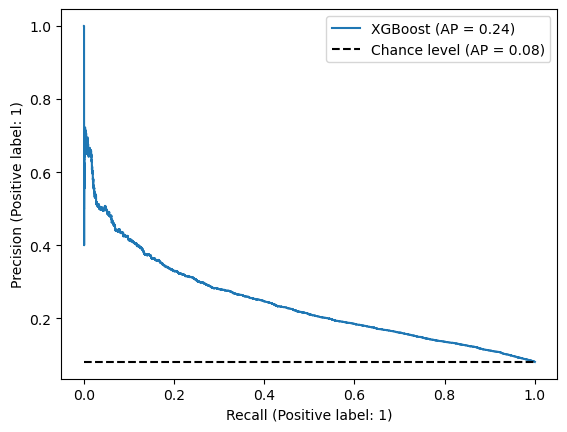

In [55]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_pred[:,1], name="XGBoost", plot_chance_level=True
)
plt.legend(loc='upper right')

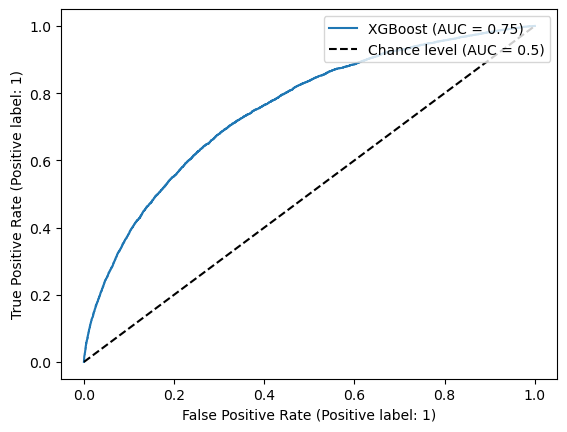

In [56]:
display = RocCurveDisplay.from_predictions(
    y_test, y_pred[:,1], name="XGBoost", plot_chance_level=True
)
plt.legend(loc='upper right')

In [57]:
y_pred = pipe.predict(X_test)
accuracy_score(y_test,y_pred)

0.7006324894720583

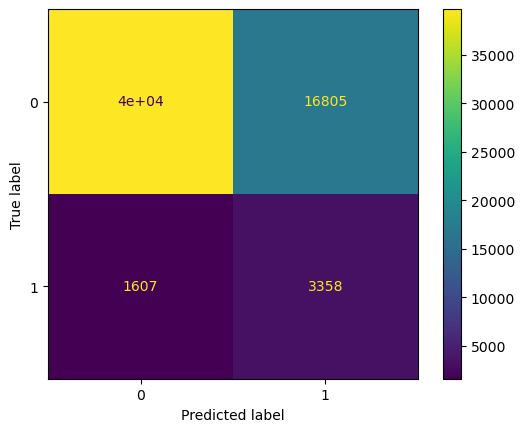

In [58]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

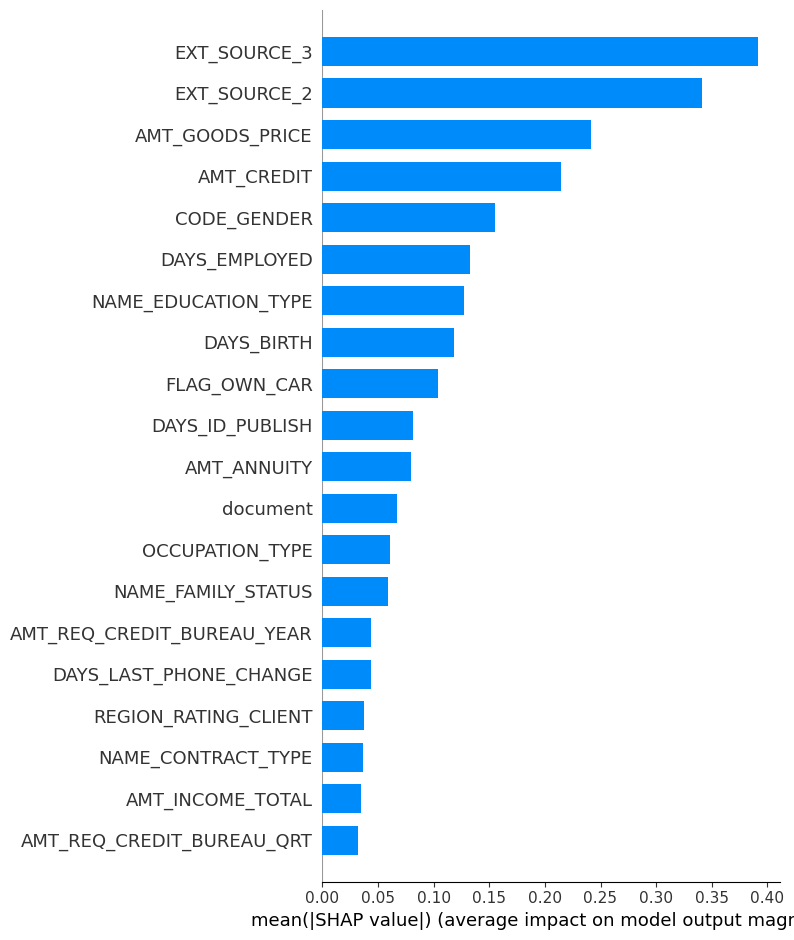

In [67]:
#set the tree explainer as the model of the pipeline
explainer = shap.Explainer(pipe['classifier'])

#apply the preprocessing to X_test
observations = pipe['preprocessor'].transform(X_test)

#get Shap values from preprocessed data
#shap_values = explainer.shap_values(observations.todense())
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar", feature_names=X_train.columns)